In [91]:
par_log_transform = True

In [92]:
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
'''
)

In [93]:
import numpy as np

import numpy.linalg as LA
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
from utils.my_plotting_lib import plot_barcodes, plot_conf_ellipse
rc('text', usetex=True)
rc('axes', labelsize=20)
rc('axes', titlesize=24)
rc('lines', linewidth=3)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)

In [94]:
with np.load('results/fsp_solutions.npz', allow_pickle=True) as fsp_sol_file:
    rna_distributions = fsp_sol_file['rna_distributions']
    rna_sensitivities = fsp_sol_file['rna_sensitivities']
    t_meas = fsp_sol_file['t_meas']

with np.load('results/fim_flowcyt.npz', allow_pickle=True) as f:
    flowcyt_prob = f['flowcyt_prob']
    
with np.load('results/flowcyt_pars.npz') as f:
    kappa=f['kappa']
    sigma_probe=f['sigma_probe']
    mu_bg=f['mu_bg']
    sigma_bg=f['sigma_bg']

with np.load('results/bursting_parameters.npz') as par:
    k_on = par['kon']
    k_off = par['koff']
    k_r = par['kr']
    gamma = par['gamma']

theta = np.array([k_on, k_off, k_r, gamma])

In [95]:
fim_single_cell = dict()

with np.load('results/fim_exact.npz') as data:
    fim_single_cell['exact'] = data['fim_exact']

with np.load('results/fim_binom.npz') as data:
    fim_single_cell['binom'] = data['fim_binom']
    
with np.load('results/fim_lowres.npz') as data:
    fim_single_cell['lowres'] = data['fim_lowres']  
    
with np.load('results/fim_composite.npz') as data:
    fim_single_cell['composite'] = data['fim_composite']      

# with np.load('results/fim_flowcyt_mc_0.npz') as data:
#     fim_flowcyt = data['fim_flowcyt']    

with np.load('results/fim_flowcyt.npz') as data:
    fim_single_cell['flowcyt'] = data['fim_flowcyt']

if par_log_transform:
    for fim in fim_single_cell.values():
        for it in range(0, len(t_meas)):
            for i in range(0,4):
                for j in range(0,4):
                    fim[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)

In [96]:
with np.load('results/flowcyt_C_matrix.npz') as file:
    C_flowcyt=file['C_flowcyt']
    yeval = file['yeval']
    xmax_flowcyt= file['xmax']
    
with np.load('results/binom_C_matrix.npz') as file:
    C_binom = file['C_binom']
    xmax_binom = file['xmax']
    ymax_binom = file['ymax']
    
with np.load('results/lowres_C_matrix.npz') as file:
    C_lowres = file['C_lowres']
    xmax_lowres = file['xmax']
    ymax_lowres = file['ymax']    

In [97]:
ncells_smfish = 1000
ncells_flowcyt = 10000
nfish_mix = np.ceil(0.51*ncells_smfish)
nflow_mix = np.floor((1-0.51)*ncells_flowcyt)
fim_mix = np.zeros((len(t_meas), 4, 4))

for it in range(0, len(t_meas)):
    fim_mix[it,:,:] = nfish_mix*fim_single_cell['lowres'][it] + nflow_mix*fim_single_cell['flowcyt'][it]      

fim_multi_cells = dict()
fim_multi_cells['mix'] = fim_mix 

for meas_type in fim_single_cell.keys():    
    fim_multi_cells[meas_type] = ncells_smfish*fim_single_cell[meas_type]
fim_multi_cells['flowcyt'] = ncells_flowcyt*fim_single_cell['flowcyt']
 
def compute_combined_fim(fim_array, dt, num_times):
    t_idx = dt*np.linspace(1, num_times, num_times, dtype=int)
    fim = fim_array[t_idx[0], :, :]
    for i in range(1, len(t_idx)):
        fim += fim_array[t_idx[i], :, :]
    return fim

num_times = 5
dt_min = 1
dt_max = int(np.floor(t_meas[-1]/num_times))
dt_array = np.linspace(dt_min, dt_max, dt_max - dt_min +1, dtype=int)

fim_multi_cells_times = dict()
det_fim_multi_cells_times = dict()

for meas_type in fim_multi_cells.keys():
    combined_fim = np.zeros((len(dt_array), 4, 4))
    det_comb_fim = np.zeros((len(dt_array),))
    
    for i in range(0, len(dt_array)):
        combined_fim[i, :, :] = compute_combined_fim(fim_multi_cells[meas_type], dt_array[i],  num_times)           
        det_comb_fim[i] = np.linalg.det(combined_fim[i,:,:])
        
    fim_multi_cells_times[meas_type] = combined_fim 
    det_fim_multi_cells_times[meas_type] = det_comb_fim 

In [98]:
opt_rates = dict()
for meas in fim_multi_cells_times.keys():
    opt_rates[meas] = np.argmax(det_fim_multi_cells_times[meas])

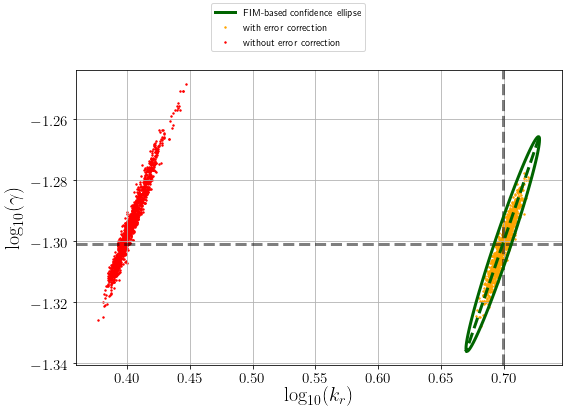

In [99]:
with np.load('results/ge_mle_correct_fits.npz') as file:
    fits_correct = file['thetas']
with np.load('results/ge_mle_misfits.npz') as file:
    fits_incorrect = file['thetas']

np.linspace(2*60/4, 2*60, 4, dtype=int)
fim = compute_combined_fim(1000*fim_single_cell['binom'], 30, 4)

fig, ax = plt.subplots(1,1)
fig.set_tight_layout(True)
fig.set_size_inches(8,5)
ax.scatter(fits_correct[:,2], fits_correct[:,3], 2, 'orange', label='with error correction')
ax.scatter(fits_incorrect[:,2], fits_incorrect[:,3], 2, 'red', label='without error correction')
plot_conf_ellipse(fim, 3, ax, [2,3], theta, 'darkgreen','FIM-based confidence ellipse')
ax.set_xlabel(r'$\log_{10}(k_r)$')
ax.set_ylabel(r'$\log_{10}(\gamma)$')

ax.grid()
leg=fig.legend(bbox_to_anchor=(0,1,1,1), loc='lower center')
fig.savefig('figs/mle_fits.png', dpi=300, bbox_inches='tight')

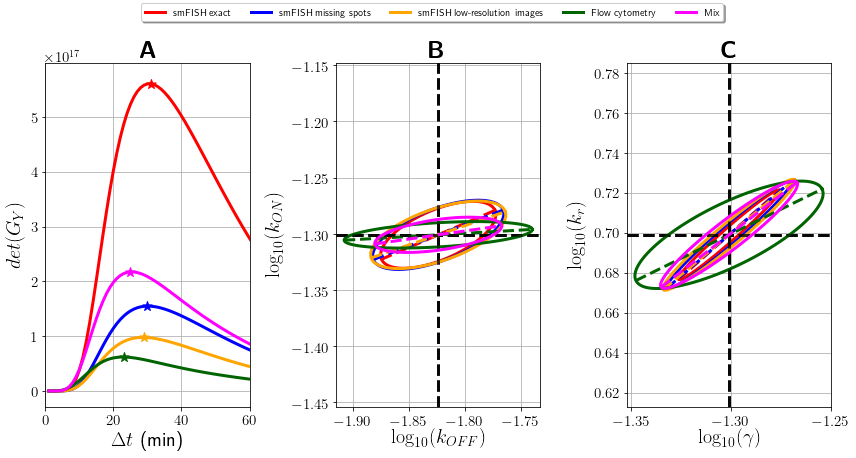

In [100]:
labels = {
        'exact': f'smFISH exact',
        'binom': f'smFISH missing spots',
        'lowres': f'smFISH low-resolution images',
        'flowcyt': f'Flow cytometry',
        'composite': f'smFISH low-resolution images with missing spots',
        'mix': f'Mix',
}

colors = {
        'exact': f'red',
        'binom': f'blue',
        'lowres': f'orange',
        'flowcyt': f'darkgreen',
        'mix': f'magenta',
        'composite': f'k',
}
    
fig, axs = plt.subplots(1,3)
fig.set_size_inches(12, 6)
fig.set_tight_layout(True)
for meas in ['exact', 'binom', 'lowres', 'flowcyt', 'mix']:
    idx_opt = opt_rates[meas]
    fims = fim_multi_cells_times[meas]
    dets = det_fim_multi_cells_times[meas]
    
    axs[0].plot(dt_array, dets, label=labels[meas], color=colors[meas])
    axs[0].scatter(dt_array[idx_opt], dets[idx_opt],
               100,
               color=colors[meas], marker='*')
    plot_conf_ellipse(fims[idx_opt], 3, 
                      axs[1], [1,0], theta, colors[meas], '')
    plot_conf_ellipse(fims[idx_opt], 3, axs[2], [3,2], theta, colors[meas], '')

h, l = axs[0].get_legend_handles_labels()
fig.legend(h, l, bbox_to_anchor=(0, 1, 1, 1), loc='lower center', ncol=5, shadow=True)
axs[0].set_xlim([0, 60])
axs[0].set_xlabel('$\Delta t$ (min)')
axs[0].set_ylabel('$\mathop{det}(G_Y)$')

for j in range(1, 3):
    axs[j].set_aspect('equal', 'datalim')
axs[1].set_ylabel('$\log_{10}({k_{ON}})$')    
axs[1].set_xlabel('$\log_{10}({k_{OFF}})$')
axs[2].set_ylabel('$\log_{10}({k_{r}})$')    
axs[2].set_xlabel('$\log_{10}({\gamma})$')

for ax in list(axs):
    ax.grid()

axs[0].set_title(r'\textbf{A}')
axs[1].set_title(r'\textbf{B}')
axs[2].set_title(r'\textbf{C}')

fig.savefig('figs/fim_dopt_slides.png', bbox_inches='tight', dpi=300)

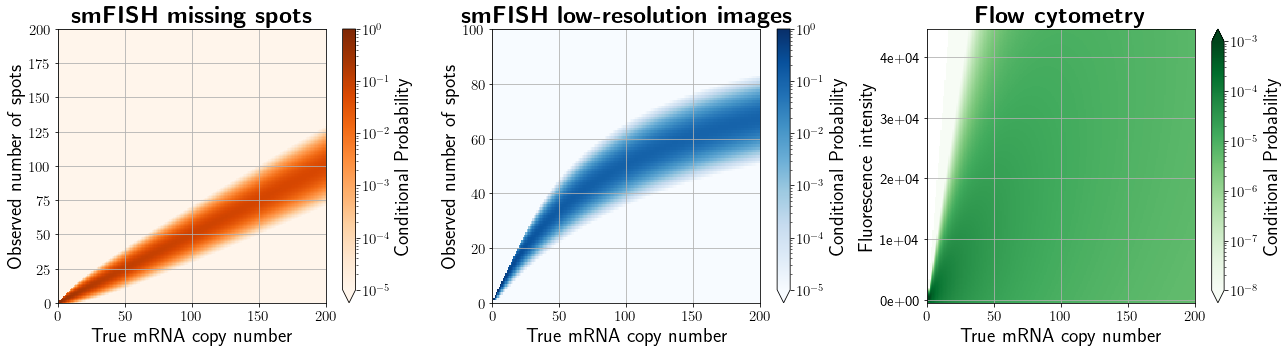

In [101]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(18, 5)
fig.set_tight_layout(True)

import matplotlib.colors as colors

C_binom[C_binom<=0.0] = 1.0e-16
p0 = axs[0].pcolorfast(C_binom[0:200,0:200], norm=colors.LogNorm(vmin=1.0E-5, vmax=1.0),
                         cmap=plt.cm.get_cmap("Oranges"))
fig.colorbar(p0, ax=axs[0], orientation='vertical', extend='min', label=r"Conditional Probability")

C_lowres[C_lowres == 0.0] = 1.0e-16
p1 = axs[1].pcolorfast(C_lowres[0:200,0:200], norm=colors.LogNorm(vmin=1.0E-5, vmax=1.0),
                         cmap=plt.cm.get_cmap("Blues"))
axs[1].set_ylim([0, 100])
fig.colorbar(p1, ax=axs[1], orientation='vertical', extend='min', label="Conditional Probability")

p2 = axs[2].pcolorfast(np.arange(0, xmax_flowcyt+1), yeval, C_flowcyt, norm=colors.LogNorm(vmin=1.0E-8, vmax=1.0E-3),
                         cmap=plt.cm.get_cmap("Greens"))
axs[2].yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
cbar2 = fig.colorbar(p2, ax=axs[2], orientation='vertical', extend='both', label=r"Conditional Probability")


for j in range(0,3):
    axs[j].set_xlabel('True mRNA copy number')
    axs[j].set_ylabel('Observed number of spots')
axs[2].set_ylabel('Fluorescence intensity')    

models = ['smFISH missing spots', 'smFISH low-resolution images', 'Flow cytometry']
for j in range(0,3):
    axs[j].set_title(rf'\textbf{{{models[j]}}}')
    axs[j].grid()
fig.savefig('figs/operators.png', dpi=300)    

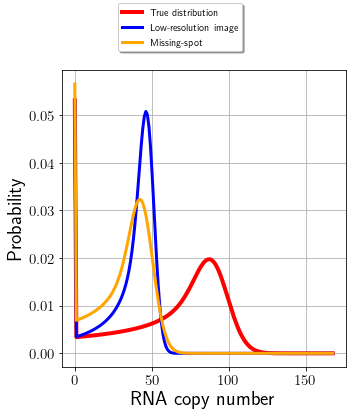

In [102]:
def plot_rna_dist_sens(ax, itime):    
    xmax = len(rna_distributions[itime])-1
    p_binom = C_binom[0:xmax+1, 0:xmax+1]@rna_distributions[itime]    
    p_lowres = C_lowres[0:xmax+1, 0:xmax+1]@rna_distributions[itime]
        
    ax.plot(np.arange(0, xmax+1), rna_distributions[itime], color='red', label='True distribution', linewidth=4)
    ax.plot(np.arange(0, xmax+1), p_lowres, color='blue', label='Low-resolution image')
    ax.plot(np.arange(0, xmax+1), p_binom, color='orange', label='Missing-spot')
    
    ax.set_xlabel('RNA copy number')
    ax.set_ylabel('Probability')    
    # 
    # ax1 = ax.twinx()   
    # stepsize = flowcyt_prob[itime]['yeval'][1] - flowcyt_prob[itime]['yeval'][0]
    # ax1.plot(flowcyt_prob[itime]['yeval']/kappa, flowcyt_prob[itime]['peval']*kappa/(stepsize*np.sum
    #                                                                            (flowcyt_prob[itime]['peval'])), 
    #         color='green', linestyle='-', label='Flow cytometry', linewidth=4)
    # ax1.tick_params(axis='y', labelcolor='green')
    # ax1.set_ylabel('Probability density', color='green')
    

fig, ax = plt.subplots(1,1)
fig.set_tight_layout(True)
fig.set_size_inches(5,5)
plot_rna_dist_sens(ax, 60)
ax.grid()
fig.legend(bbox_to_anchor=(0,1,1,1), loc='lower center', shadow=True)
fig.savefig('figs/distorted_dists_slides.png', bbox_inches='tight', dpi=300)

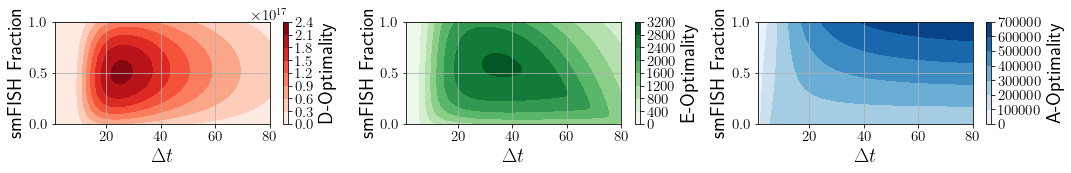

In [103]:
with np.load('results/fsp_solutions.npz', allow_pickle=True) as fsp_sol_file:
    rna_distributions = fsp_sol_file['rna_distributions']
    rna_sensitivities = fsp_sol_file['rna_sensitivities']
    t_meas = fsp_sol_file['t_meas']

with np.load('results/fim_flowcyt.npz', allow_pickle=True) as f:
    flowcyt_prob = f['flowcyt_prob']
    
with np.load('results/flowcyt_pars.npz') as f:
    kappa=f['kappa']
    sigma_probe=f['sigma_probe']
    mu_bg=f['mu_bg']
    sigma_bg=f['sigma_bg']

with np.load('results/bursting_parameters.npz') as par:
    k_on = par['kon']
    k_off = par['koff']
    k_r = par['kr']
    gamma = par['gamma']

theta = np.array([k_on, k_off, k_r, gamma])

fim_single_cell = dict()

with np.load('results/fim_exact.npz') as data:
    fim_single_cell['exact'] = data['fim_exact']

with np.load('results/fim_binom.npz') as data:
    fim_single_cell['binom'] = data['fim_binom']
    
with np.load('results/fim_lowres.npz') as data:
    fim_single_cell['lowres'] = data['fim_lowres']  
    
with np.load('results/fim_composite.npz') as data:
    fim_single_cell['composite'] = data['fim_composite']      

with np.load('results/fim_flowcyt.npz') as data:
    fim_single_cell['flowcyt'] = data['fim_flowcyt']

if par_log_transform:
    for fim in fim_single_cell.values():
        for it in range(0, len(t_meas)):
            for i in range(0,4):
                for j in range(0,4):
                    fim[it, i, j] *= theta[i]*theta[j]*np.log(10)*np.log(10)   
    
def find_min_eigv(M):
    w = np.linalg.eigvals(M)
    return np.min(w)

def find_trace(M):
    return np.sum(np.diagonal(M))

with np.load('results/fim_multifi.npz') as file:
    fim_multifi = file['fim_multifi']
    p_grid = file['p_grid']
    dt_array = file['dt_array']

info_meas = ['dopt', 'eopt', 'aopt']    
eval_funs = {'dopt': np.linalg.det, 'eopt': find_min_eigv, 'aopt': find_trace}
info_colors = {'dopt': 'Reds', 'eopt': 'Greens', 'aopt': 'Blues'}
info_labels = {'dopt': 'D-Optimality', 'eopt': 'E-Optimality', 'aopt': 'A-Optimality'}
    
landscapes = dict()    
for key in info_meas:
    landscapes[key] = np.zeros((fim_multifi.shape[0], fim_multifi.shape[1]))    
    for i in range(landscapes[key].shape[0]):
        for j in range(landscapes[key].shape[1]):
            landscapes[key][i, j] = eval_funs[key](fim_multifi[i, j, :, :])                      

import matplotlib.colors as colors
fig, axs = plt.subplots(1, len(info_meas))
fig.set_size_inches(5*len(info_meas),2.5)
fig.set_tight_layout(True)

for i in range(0, len(info_meas)):
    heatmap = axs[i].contourf(dt_array, p_grid, landscapes[info_meas[i]], cmap=plt.cm.get_cmap(info_colors[info_meas[i]]))
    axs[i].set_xlabel(r'$\Delta t$')
    axs[i].set_ylabel('smFISH Fraction')
    axs[i].grid()
    fig.colorbar(heatmap, ax=axs[i], extend='both', label=info_labels[info_meas[i]])
fig.savefig('figs/multifi_slides.png', dpi=300, bbox_inches='tight')    

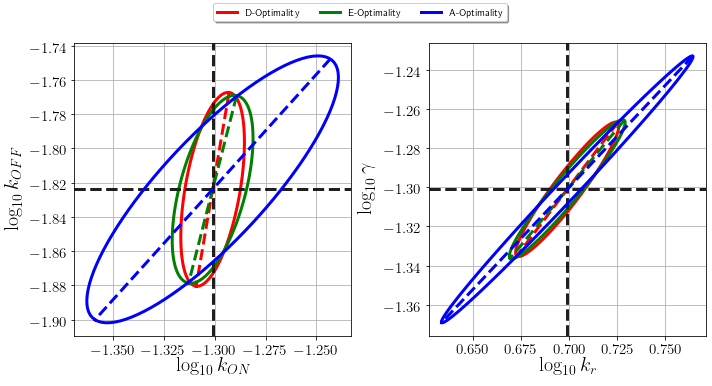

In [104]:
fig, axs = plt.subplots(1, 2)
fig.set_tight_layout(True)
fig.set_size_inches(10,5)
clrs = ['red', 'green', 'blue']
for i in range(0, len(info_meas)):
    idx_opt = np.argmax(landscapes[info_meas[i]])
    imax, jmax = np.unravel_index(idx_opt, landscapes[info_meas[i]].shape)
    M = fim_multifi[imax, jmax, :, :]
    plot_conf_ellipse(M, 3, axs[0], [0,1], theta, color=clrs[i], label=info_labels[info_meas[i]])
    plot_conf_ellipse(M, 3, axs[1], [2,3], theta, color=clrs[i], label=info_labels[info_meas[i]])

axslabels = [{'x': '$\log_{10}{k_{ON}}$', 'y': '$\log_{10}{k_{OFF}}$'},
            {'x': '$\log_{10} k_r$', 'y': '$\log_{10}\gamma$'}]
for i in range(0,len(axs)):
    axs[i].set_xlabel(axslabels[i]['x'])
    axs[i].set_ylabel(axslabels[i]['y'])
    axs[i].grid()
    
h, l = axs[0].get_legend_handles_labels()
fig.legend(h,l, bbox_to_anchor=(0,1,1,1), loc='lower center', ncol=3, shadow=True)
fig.savefig('multifi_ellipes.png', bbox_inches='tight', dpi=300)